# Constant CI

In [ ]:
I_input, V_ouput, spikes_out = generate_dataset(1, 4, 4, 'const', random_state)

  0%|          | 0/1 [00:00<?, ?it/s]

Changed dt


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


In [ ]:
I_input.shape

(1, 8, 5000)

In [ ]:
V_ouput.shape

(1, 5000)

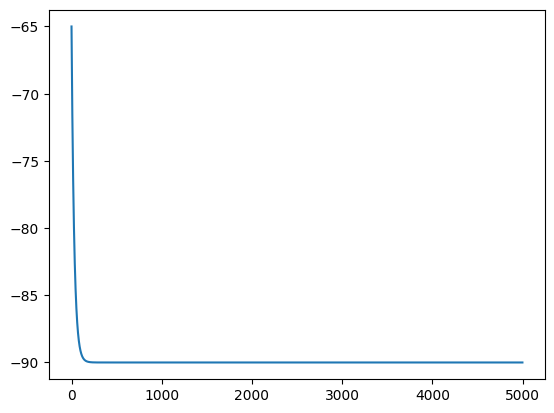

In [ ]:
plt.plot(V_ouput[0, :].flatten())

In [ ]:
spikes_out.shape

(1, 5000)

In [ ]:
class IFDNN(torch.nn.Module):

    def __init__(self, N_syn, win_size):
        super().__init__()
        self.win_size = win_size
        self.conv = torch.nn.Conv1d(in_channels = N_syn, out_channels = 1, kernel_size = self.win_size, padding = "valid")
        self.spike_conv = torch.nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 1, padding = "valid")
        self.v_conv = torch.nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 1, padding = "valid")

    def forward(self, I_input):
        # Causal padding, so that the kernel uses [... t-1] to predict [t]
        I_input = torch.nn.functional.pad(I_input, (self.win_size - 1, 0))
        out = self.conv(I_input)

        spike_out = self.spike_conv(out)
        spike_out = torch.nn.functional.logsigmoid(spike_out)

        v_out = self.v_conv(out)

        return v_out, spike_out
    
model = IFDNN(N_syn = N_syn, win_size = win_size)

In [ ]:
# https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/8
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

8005

In [ ]:
all_train_loss = []
all_test_loss = []

model = IFDNN(N_syn = N_syn, win_size = win_size)
I_input_test, V_ouput_test, spike_times_test = generate_dataset(32)

100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


In [ ]:
for batch_num in range(10):

    I_input_train, V_ouput_train, spike_times_train = generate_dataset(32)

    train_loss_history, test_loss_history = train(
        num_epoch = 15,
        model = model,
        device_name = "cpu",
        lr = 0.0001, # 0.0003
        I_train = I_input_train,
        V_train = V_ouput_train,
        spike_times_train = spike_times_train,
        I_test = I_input_test,
        V_test = V_ouput_test,
        spike_times_test = spike_times_test,
        sim_time_ms = sim_time_ms
    )

    all_train_loss.extend(train_loss_history)
    all_test_loss.extend(test_loss_history)

100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


[Epoch 0]:
              train_loss = 8312.8779296875,
              test_MSE = 4653.646484375,
              test_BCE = 3560.997802734375,
              test_loss = 8214.64453125,
              test_acc = 0.99223125
              test_AUC = 0.5215743231415706
[Epoch 1]:
              train_loss = 8217.353515625,
              test_MSE = 4647.244140625,
              test_BCE = 3476.518798828125,
              test_loss = 8123.7626953125,
              test_acc = 0.99223125
              test_AUC = 0.5358913307759657
[Epoch 2]:
              train_loss = 8123.45751953125,
              test_MSE = 4640.8505859375,
              test_BCE = 3393.54638671875,
              test_loss = 8034.39697265625,
              test_acc = 0.99223125
              test_AUC = 0.5493274934352608
[Epoch 3]:
              train_loss = 8031.19921875,
              test_MSE = 4634.4677734375,
              test_BCE = 3312.0869140625,
              test_loss = 7946.5546875,
              test_acc = 0.99223125

 25%|██▌       | 8/32 [00:03<00:11,  2.14it/s]


KeyboardInterrupt: 

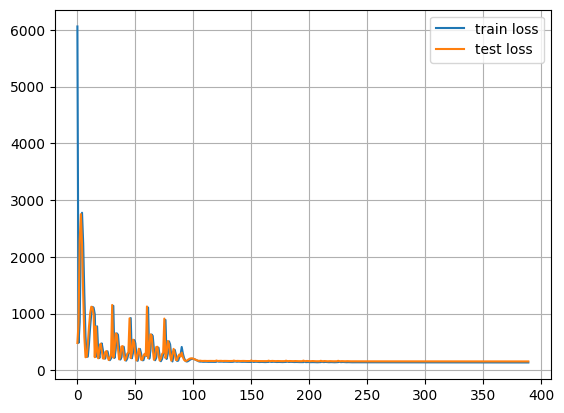

In [ ]:
plt.plot(all_train_loss, label = "train loss")
plt.plot(all_test_loss, label = "test loss")
plt.grid()
plt.legend()

In [ ]:
conv_params = list(model.parameters())[0].detach().numpy()[0]
conv_params.shape

(100, 80)

In [ ]:
np.median(conv_params)

0.18005961

In [ ]:
conv_params

array([[ 0.54131   ,  0.47349748,  0.41318563, ...,  0.44084486,
         0.49930152,  0.56764746],
       [ 1.0470155 ,  0.948186  ,  0.8823584 , ...,  0.50625366,
         0.58276355,  0.6844535 ],
       [ 0.7273737 ,  0.6418907 ,  0.5769223 , ...,  0.8703752 ,
         0.9998561 ,  1.1431091 ],
       ...,
       [-1.0391077 , -0.90187323, -0.81583726, ..., -1.1479957 ,
        -1.273328  , -1.364298  ],
       [-0.41437674, -0.35250315, -0.28700277, ..., -1.4693499 ,
        -1.6054579 , -1.7222424 ],
       [-0.5548225 , -0.50515604, -0.4474204 , ..., -2.075593  ,
        -2.2380078 , -2.3876126 ]], dtype=float32)

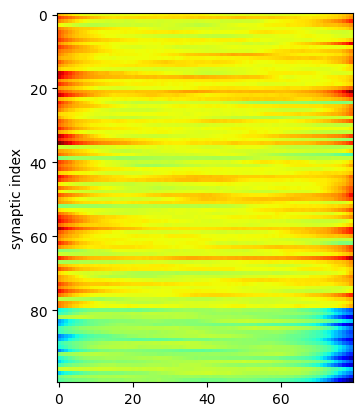

In [ ]:
import seaborn as sns
plt.imshow(conv_params, cmap = 'jet')
plt.ylabel("synaptic index");

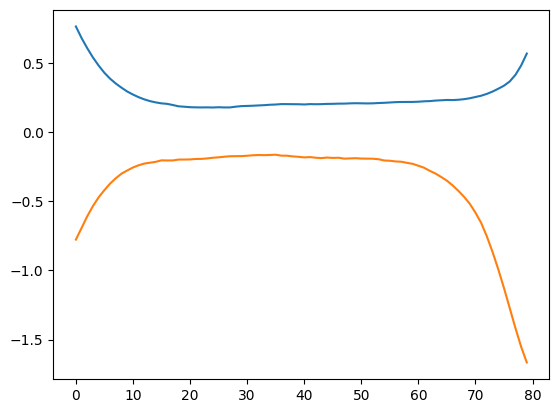

In [ ]:
exc_params = conv_params[:80]
inh_params = conv_params[80:]
plt.plot(exc_params.mean(axis = 0))
plt.plot(inh_params.mean(axis = 0))

24068021


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


[Epoch 0]:
              train_loss = 7827.56298828125,
              test_MSE = 5395.0341796875,
              test_BCE = 577.7308959960938,
              test_loss = 5972.76513671875,
              test_acc = 0.99425
              test_AUC = 0.6075149500934722
[Epoch 0]:
              train_loss = 6376.6494140625,
              test_MSE = 4894.3251953125,
              test_BCE = 197.52513122558594,
              test_loss = 5091.85009765625,
              test_acc = 0.99425
              test_AUC = 0.5854205157918904


In [ ]:
torch.tensor(spike_times_train).shape

torch.Size([1, 4000])